# Clustering and Visualization of Phoebe dataset

## Components
* Create dataset with every row linked to the image it was generated from
    * Will need to extract images from videos like this:
    `ffmpeg -ss 00:23:00 -i video.mp4 -frames:v 1 out_time.jpg`


In [217]:
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
DATASET_FILE = "Phoebe_dataset4.zip"
full_path = os.path.abspath(DATASET_FILE[:-4])
if not os.path.exists(full_path):
    !unzip -o $DATASET_FILE;

---
## Load datasets
### Helper functions

In [218]:
import numpy as np
# import os, os.path
from typing import List, Dict, Union, Any
import csv
import uuid
import re
import time
import datetime
import logging

# Paths
PATH_DATASET = "Phoebe_dataset4"
PATH_AU_INTENSITY = "single_person_au_intensity"
PATH_AU_PRESENCE = "single_person_au_presence"
PATH_TRAIN = "train"
PATH_TEST = "test"
PATH_TRAINING_VIDEOS = PATH_DATASET + "/videos/train"
PATH_PROCESSED_IMAGES = PATH_DATASET + "/processed_images"
PATH_TRAINING_CSV = f"./{PATH_DATASET}/{PATH_AU_INTENSITY}/{PATH_TRAIN}/"

# General
EXT_MP4 = "mp4"

# Stores
IMAGE_STORE = {}

log = logging.getLogger()
log.setLevel(logging.DEBUG)

if not os.path.isdir(PATH_PROCESSED_IMAGES):
    os.mkdir(PATH_PROCESSED_IMAGES)

In [219]:
def load_dataset(filename: str) -> List[Union[str, float]]:
    """Load dataset for a single csv/video pair.
    
    :param filename: name of video and csv without an extension.
    
    :return: result dataset for csv/video pair.
    """
    # Load csv with python library so that first column may be removed.
    print(filename)
    raw_data = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        
        for index, row in enumerate(reader):
            if index == 0:
                row = [x.strip() for x in row]
                # Rename column row
                row[0] = "frame"
                
                # Create a new column to save filename the row came from.
                # This is used to extract image when needed (filename + frame are needed)
                row.insert(0, "filename")
                
            elif row[0] != "":
                # Create an image for every row and add to dictionnary {id: path}
                filename_without_ext: str = re.findall(r"[0-9]+", filename)[-1]
                row.insert(0, filename_without_ext)
            raw_data.append(row)
    
    return raw_data

def create_full_dataset(training_files) -> List[Union[str, float]]:
    """Load dataset for every csv/video pair.
    
    :param training_files: list of csv files.
    
    :return: full dataset results
    """
    assert(isinstance(training_files, list)) 
    full_dataset = []
    for file in training_files:
        dataset = load_dataset(file)
        if len(full_dataset) == 0:
            full_dataset = dataset
        else:
            full_dataset.extend(dataset[1:])
    return full_dataset

### Get image
If image has not been extracted for given id, extract it from corresponding video. This is made easy because the matrix stores the video name (without the extension) and the frame number.

Pass the entire row of data to the `extract_image_for_frame` function in order to get the correct frame.

In [220]:
from IPython.display import display, Image
import datetime

# %%capture
def extract_image_for_frame(image_path: str, video_name: str, frame: str):
    """Extracts a frame from a video given a timestamp in seconds.
    
    :param orig_filename: name of video for which timestamp applies
    :param row_id: id of row and image
    
    :return: name of the image without its extension.
    """

    video_filepath = PATH_TRAINING_VIDEOS + f"/{video_name}.{EXT_MP4}"
    
    # Data was sampled at about 30fps. Get time at which it is in the video
    time_in_seconds = (1/30) * frame
    time_datetime = datetime.timedelta(seconds=time_in_seconds)
    
    log.debug(f"Extracting frame at time {time_datetime} from path {video_filepath}")        
    # command = f"ffmpeg -i {video_filepath} -r 30 {image_path}.jpg"
    
    command = f"ffmpeg -i {video_filepath} -ss {time_datetime} -vframes 1 {image_path}.jpg -n"
    log.debug(f"Running command: {command}")

    print(f"### ")
    !$command;

    
def show_image(row: List[Any]):
    """
    :param row: a row of data
    """
    log.debug(f"### Getting image for row: {row}")
    
    video_name = int(row[0])
    frame = int(row[0])
    image_name = f"{video_name:03}{frame:03}"
    image_path = PATH_PROCESSED_IMAGES + image_name
    if not os.path.exists(image_path):
        extract_image_for_frame(image_path, video_name, frame)
        
    try:
        image = Image(filename=f'{image_path}.jpg')
        display(image)
    except IOError as e:
        print(e)       

### Run dataset preparation pipeline

In [221]:
# %%capture
training_files: List[str] = [f"{PATH_TRAINING_CSV}{name}" for 
                             name in os.listdir(f"{PATH_TRAINING_CSV}") if 
                             name[-4:] == ".csv"]

print(training_files[0:2])
# Load datasets
full_dataset = create_full_dataset(training_files)

['./Phoebe_dataset4/single_person_au_intensity/train/6.csv', './Phoebe_dataset4/single_person_au_intensity/train/40.csv']
./Phoebe_dataset4/single_person_au_intensity/train/6.csv
./Phoebe_dataset4/single_person_au_intensity/train/40.csv
./Phoebe_dataset4/single_person_au_intensity/train/41.csv
./Phoebe_dataset4/single_person_au_intensity/train/7.csv
./Phoebe_dataset4/single_person_au_intensity/train/43.csv
./Phoebe_dataset4/single_person_au_intensity/train/5.csv
./Phoebe_dataset4/single_person_au_intensity/train/4.csv
./Phoebe_dataset4/single_person_au_intensity/train/42.csv
./Phoebe_dataset4/single_person_au_intensity/train/46.csv
./Phoebe_dataset4/single_person_au_intensity/train/1.csv
./Phoebe_dataset4/single_person_au_intensity/train/47.csv
./Phoebe_dataset4/single_person_au_intensity/train/3.csv
./Phoebe_dataset4/single_person_au_intensity/train/45.csv
./Phoebe_dataset4/single_person_au_intensity/train/44.csv
./Phoebe_dataset4/single_person_au_intensity/train/50.csv
./Phoebe_datas

In [222]:
print(len(full_dataset))
print(full_dataset[0:5])

3217
[['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'], ['6', '0', '0', '0.98', '1', '0.11', '0.0', '0.0', '0.0', '1.33', '2.09', '0.0', '1.1', '1.62', '0.08', '0.1', '0.15', '0.0', '0.0', '0.0', '0.29', '0.0'], ['6', '1', '0', '0.98', '1', '0.04', '0.0', '0.13', '0.08', '1.42', '2.2', '0.13', '1.14', '1.61', '0.03', '0.14', '0.4', '0.0', '0.0', '0.12', '0.1', '0.01'], ['6', '2', '0', '0.98', '1', '0.0', '0.0', '0.13', '0.08', '1.43', '2.08', '0.13', '1.02', '1.53', '0.02', '0.1', '0.35', '0.17', '0.0', '0.23', '0.14', '0.13'], ['6', '3', '0', '0.98', '1', '0.0', '0.0', '0.08', '0.15', '1.43', '1.84', '0.07', '0.86', '1.36', '0.06', '0.01', '0.12', '0.17', '0.08', '0.18', '0.28', '0.3']]


11:21:41 DEBUG:### Getting image for row: ['6', '0', '0', '0.98', '1', '0.11', '0.0', '0.0', '0.0', '1.33', '2.09', '0.0', '1.1', '1.62', '0.08', '0.1', '0.15', '0.0', '0.0', '0.0', '0.29', '0.0']
11:21:41 DEBUG:Extracting frame at time 0:00:00.200000 from path Phoebe_dataset4/videos/train/6.mp4
11:21:41 DEBUG:Running command: ffmpeg -i Phoebe_dataset4/videos/train/6.mp4 -ss 0:00:00.200000 -vframes 1 Phoebe_dataset4/processed_images006006.jpg -n


### 
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.59)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags=-fno-stack-check --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  

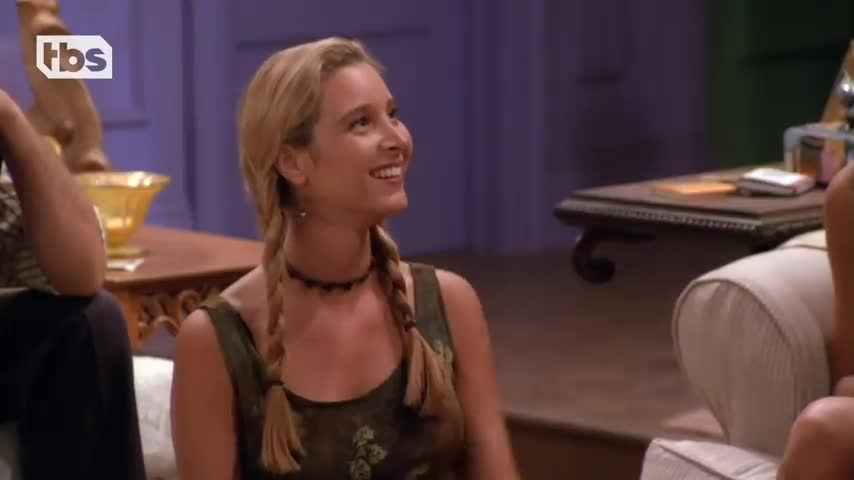

In [223]:
# Images in Image datastore are "fileid_frame"
show_image(full_dataset[1])

In [239]:
count = 3
print(f"First {count} rows of dataset:\n")
for i in range(0, count):
    print(str(full_dataset[i]) + "\n")

First 3 rows of dataset:

['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

['6', '0', '0', '0.98', '1', '0.11', '0.0', '0.0', '0.0', '1.33', '2.09', '0.0', '1.1', '1.62', '0.08', '0.1', '0.15', '0.0', '0.0', '0.0', '0.29', '0.0']

['6', '1', '0', '0.98', '1', '0.04', '0.0', '0.13', '0.08', '1.42', '2.2', '0.13', '1.14', '1.61', '0.03', '0.14', '0.4', '0.0', '0.0', '0.12', '0.1', '0.01']



---
## Preprocess and cleanup data
- [X] Remove rows with confidence < 85
- [X] Remove rows with empty value(s)

### Compare ML algorithms for
- [ ] Scaled AU between 0 and 1, and unscaled AUs

In [248]:
from pprint import pprint

CONFIDENCE_LEVEL = 0.85

full_dataset_header = full_dataset[0]
keys_full_dataset = {j: i for i, j in enumerate(full_dataset_header)}

print(f"keys_full_dataset:")
pprint(keys_full_dataset)

print(f"type(full_dataset): \t{type(full_dataset)}")      

# NOTE: because full_dataset stores strings in the first row, it must be skipped
# in list comprehensions. Furthermore, the strings also need to be cast to whatever
# format they are being compared to (int, float).

# Only keep rows that have "success = 1"
full_dataset_all_success = [x for x in full_dataset[1:] 
                            if int(x[keys_full_dataset["success"]]) == 1]
log.debug("Removed {} rows with 'success = 0'".format(
    len(full_dataset) - len(full_dataset_all_success)))

# Only keep rows that have "confidence > 0.85"
full_dataset_good_confidence = [x for x in full_dataset_all_success[1:] 
                                if float(x[keys_full_dataset["confidence"]]) >= CONFIDENCE_LEVEL]
log.debug("Removed {} rows with 'confidence < 0'".format(
    len(full_dataset_all_success) - len(full_dataset_good_confidence)))

# Do not edit final_dataset. It is there to keep indempotency in case more filters
# need to be added above. The final dataset has all unwanted rows removed, but still
# has the header row.
final_dataset = full_dataset_good_confidence

11:36:03 DEBUG:Removed 86 rows with 'success = 0'
11:36:03 DEBUG:Removed 43 rows with 'confidence < 0'


keys_full_dataset:
{'AU01_r': 5,
 'AU02_r': 6,
 'AU04_r': 7,
 'AU05_r': 8,
 'AU06_r': 9,
 'AU07_r': 10,
 'AU09_r': 11,
 'AU10_r': 12,
 'AU12_r': 13,
 'AU14_r': 14,
 'AU15_r': 15,
 'AU17_r': 16,
 'AU20_r': 17,
 'AU23_r': 18,
 'AU25_r': 19,
 'AU26_r': 20,
 'AU45_r': 21,
 'confidence': 3,
 'face_id': 2,
 'filename': 0,
 'frame': 1,
 'success': 4}
type(full_dataset): 	<class 'list'>


In [249]:
from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

only_AU_info = [x[keys_full_dataset["AU01_r"]:keys_full_dataset["AU_r"]] 
                for x in final_dataset[1:]]
X_train = np.array(final_dataset[1:])

# Remove empty or null values

# split = np.hsplit(X_train, np.array([5]))
# print(split)
# X_not_minmax = 
# X_need_minmax = 

# X_train_minmax = np.fit_transform(X_train)
    
print(f"X_train.shape: \t\t{X_train.shape}")

X_train.shape: 		(3087, 22)


---
## Gausian Mixture Model

11:33:27 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
11:33:27 DEBUG:X_train.shape: (3087, 17)


[['0.0' '0.0' '0.13' '0.08' '1.43' '2.08' '0.13' '1.02' '1.53' '0.02'
  '0.1' '0.35' '0.17' '0.0' '0.23' '0.14' '0.13']
 ['0.0' '0.0' '0.08' '0.15' '1.43' '1.84' '0.07' '0.86' '1.36' '0.06'
  '0.01' '0.12' '0.17' '0.08' '0.18' '0.28' '0.3']]


11:33:28 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:33:28 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:33:28 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:33:28 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[[0.97  0.    0.    0.    0.    0.    0.    0.    0.    0.029 0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.09  0.    0.    0.    0.    0.    0.    0.91  0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.003 0.    0.    0.    0.    0.    0.    0.997 0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.223 0.    0.    0.    0.    0.    0.    0.777 0.    0.
  0.    0.    0.    0.   ]]


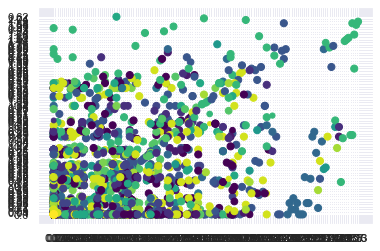

In [246]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.mixture import GaussianMixture


X_train_with_labels = X_train

# X_train now only contains facial Action Units.
# Only do this operation once.
if X_train.shape[1] != 17:
    log.debug("Deleting columns from X_train to keep only 17 AU")
    X_train = X_train[:, 5:]

assert(X_train.shape[1] == 17)
log.debug(f"X_train.shape: {X_train.shape}")

print(X_train[0:2])

gmm = GaussianMixture(n_components=16).fit(X_train)
probs = gmm.predict_proba(X_train) 
print(probs[:5].round(3))

labels = gmm.predict(X_train)
size = 50 * probs.max(1) ** 2 # square emphasizes differences
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=size, cmap='viridis');